In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import xrft # for the FFT on xarrays

In [82]:
def plot_map_nps(lon,lat,field,vmin,vmax,cmap,str_title,str_name):
    
    fig = plt.figure(figsize=(12,10))

    ax = plt.axes(projection=ccrs.NorthPolarStereo()) # Mollweide # NorthPolarStereo
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
    ax.gridlines()

    pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
    cbar = plt.colorbar(pc)
    cbar.ax.tick_params(labelsize=14) 
    ax.set_title(str_title,fontsize=16)

    plt.savefig(str_name+'.png',bbox_inches='tight')
    
def plot_map_nps_diff(lon,lat,field2,field1,vmin,vmax,cmap,str_title,str_name):
    
    fig = plt.figure(figsize=(12,10))

    ax = plt.axes(projection=ccrs.NorthPolarStereo()) # Mollweide # NorthPolarStereo
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
    ax.gridlines()

    cs = ax.contour(lon,lat,field1,transform=ccrs.PlateCarree(),colors='k')
    plt.clabel(cs,fontsize=14)
    pc = ax.pcolormesh(lon,lat,field2-field1,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
    cbar = plt.colorbar(pc)
    cbar.ax.tick_params(labelsize=14) 
    ax.set_title(str_title,fontsize=16)

    plt.savefig(str_name+'_diff.png',bbox_inches='tight')


def plot_map_sps(lon,lat,field,vmin,vmax,cmap,str_title,str_name):
    
    fig = plt.figure(figsize=(12,10))

    ax = plt.axes(projection=ccrs.SouthPolarStereo()) # Mollweide # NorthPolarStereo
    ax.coastlines()
    ax.set_extent([-180, 180, -20, -90], crs=ccrs.PlateCarree())
    ax.gridlines()

    pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
    cbar = plt.colorbar(pc)
    cbar.ax.tick_params(labelsize=14) 
    ax.set_title(str_title,fontsize=16)

    plt.savefig(str_name+'_sps.png',bbox_inches='tight')

def plot_map_nps_strack(lon,lat,field,vmin,vmax,cmap,str_title,str_name):
    
    fig = plt.figure(figsize=(12,10))

    ax = plt.axes(projection=ccrs.NorthPolarStereo()) # Mollweide # NorthPolarStereo
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
    ax.gridlines()

    pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
    ct = ax.contour(lon,lat,field,transform=ccrs.PlateCarree(),colors='k')
    plt.clabel(ct,fontsize=12)
    cbar = plt.colorbar(pc)
    cbar.ax.tick_params(labelsize=14) 
    ax.set_title(str_title,fontsize=16)

    plt.savefig(str_name+'.png',bbox_inches='tight')

def crop_field_lat(field,lat,minlat,maxlat):
    # Crop a field over a given range of latitude, as indicated by minlat and maxlat
    
    valid_indices = np.argwhere((lat>minlat)&(lat<maxlat))
    y_min = valid_indices.min(axis=0)[0]
    y_max = valid_indices.max(axis=0)[0]
    
    if len(field.shape)==2:
        crop_field = field[y_min:y_max+1,:]
    else:
        crop_field = field[y_min:y_max+1]

    return crop_field

def compute_meridional_average(lat,field,minlat,maxlat):
    # Compute the meridional average in the range indicated by minlat and maxlat
    
    crop_field = crop_field_lat(field,lat,minlat,maxlat)
    crop_lat = crop_field_lat(lat,lat,minlat,maxlat)*np.pi/180 # Latitude converted to radians.
    
    dlat = np.diff(crop_lat) # Compute the delta latitude.
    # Use the trapezoidal rule to perform the integral.
    integrand = 0.5*(crop_field[1:,:]+crop_field[:-1,:])*dlat[:,np.newaxis]*np.cos(0.5*(crop_lat[1:,np.newaxis]+crop_lat[:-1,np.newaxis]))

    numerator = np.sum(integrand, axis=0)
    denominator = np.sin(crop_lat[-1])-np.sin(crop_lat[0])
    
    return numerator/denominator

def plot_meridional_average(lon,lat,field,minlat,maxlat,str_title,str_name):
    line = compute_meridional_average(lat,field,minlat,maxlat)
    
    fig = plt.figure(figsize=(12,4))
    plt.plot(lon,line)
    plt.xticks(np.arange(0,360,60))
    
    plt.title(str_title + ' meridional average, lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
    plt.tick_params(axis='both',labelsize=14)
    plt.xlabel('Longitude [°E]',fontsize=14)
    plt.grid()
    
    plt.savefig(str_name+'_meridional_average.png',bbox_inches='tight')

def compute_annular_average(lat,field,minlat,maxlat):
    # Compute the meridional average in the range indicated by minlat and maxlat
    
    crop_field = crop_field_lat(field,lat,minlat,maxlat)
    crop_lat = crop_field_lat(lat,lat,minlat,maxlat)*np.pi/180 # Latitude converted to radians.
    
    dlat = np.diff(crop_lat) # Compute the delta latitude.
    dlon = np.diff(lon)[0]*np.pi/180 # This is uniform.
    # Use the trapezoidal rule to perform the integral.
    integrand = 0.5*(crop_field[1:,:]+crop_field[:-1,:])*dlon*dlat[:,np.newaxis]*np.cos(0.5*(crop_lat[1:,np.newaxis]+crop_lat[:-1,np.newaxis]))

    numerator = np.sum(integrand)
    denominator = 2*np.pi*(np.sin(crop_lat[-1])-np.sin(crop_lat[0]))
    
    return numerator/denominator

In [ ]:
##### TEST AND DEBUG FOR MERIDIONAL AND ANNULAR AVERAGES ####

In [ ]:
plt.plot(0.5*(lat[1:]+lat[:-1]),np.diff(lat),'o')
#plt.xlim(20,40)

In [ ]:
# Meridional average.
minlat = 20
maxlat = 60

crop_field = crop_field_lat(field,lat,minlat,maxlat)
crop_lat = crop_field_lat(lat,lat,minlat,maxlat)*np.pi/180
test_field = np.ones_like(crop_field)

integrand = 0.5*(test_field[1:,:]+test_field[:-1,:])
dlat = np.diff(crop_lat)
#dlon = np.diff(lon)[0] # This is uniform

test = integrand * dlat[:,np.newaxis] * np.cos(0.5*(crop_lat[1:,np.newaxis]+crop_lat[:-1,np.newaxis]))

a = np.sum(test, axis=0)[0]
b = (np.sin(crop_lat[-1])-np.sin(crop_lat[0]))

print(a,b,a/b)

# If I integrate a field that is flat and equal to one I shoul get
# 2 * pi * (sin(maxlat) - sin(minlat))
# which is equal to 4 * pi if the extreme of integration are -90 and 90. 

In [ ]:
# Annular average.
minlat = 20
maxlat = 60

crop_field = crop_field_lat(field,lat,minlat,maxlat)
crop_lat = crop_field_lat(lat,lat,minlat,maxlat)*np.pi/180
test_field = np.ones_like(crop_field)

integrand = 0.5*(test_field[1:,:]+test_field[:-1,:])
dlat = np.diff(crop_lat)
dlon = np.diff(lon)[0]*np.pi/180 # This is uniform

test = integrand * dlon * dlat[:,np.newaxis] * np.cos(0.5*(crop_lat[1:,np.newaxis]+crop_lat[:-1,np.newaxis]))

a = np.sum(test)
b = 2*np.pi*(np.sin(crop_lat[-1])-np.sin(crop_lat[0]))

print(a,b,a/b)

# If I integrate a field that is flat and equal to one I shoul get
# 2 * pi * (sin(maxlat) - sin(minlat))
# which is equal to 4 * pi if the extreme of integration are -90 and 90. 

In [ ]:
test_field = 4*np.ones_like(field) #np.copy(field)

#compute_meridional_average(lat,test_field,minlat=-20,maxlat=60)
compute_annular_average(lat,test_field,minlat=-20,maxlat=60)

In [ ]:
###############

In [112]:
def get_storm_track(ds_daily,varname='gh_500'):
    # Compute the storm track defined as the standard deviation of the signal of varname band-pass
    # filtered in the 2-7 days window (D'Andrea et al., 2024 use the 500 geopotential height as an input).
    # The fields are daily here and so the band pass is not needed as the Nyquist frequency corresponds to 2 days.
    # So we just need to high-pass filter at the 1/7d frequency. We use a rectangula filter.
    
    from scipy.fft import fft, fftshift, fftfreq, ifft

    nyears = 100 # number of years to be selected
    # Do not distinguish the seasons.
    signal = ds_daily[varname].isel(time=slice(1,10*365)).values
    t = np.arange(np.shape(signal)[0])
    sp = fft(signal-np.mean(signal),axis=0)
    freq = fftfreq(len(t))
    ffilter = np.ones_like(freq)*np.heaviside(freq-1/7,0)+np.ones_like(freq)*np.heaviside(-freq-1/7,0)
    filtered = ifft(ffilter[:,np.newaxis,np.newaxis]*sp,axis=0)
    
    strack = np.std(filtered,axis=0)

    # To separate the storm tracks by season we assume that the output file starts in January.
    first_file = 1
    for kk in range(nyears):
        if first_file:
            #filt_JJA=filtered[kk*12+5:kk*12+8]
            #filt_JF=filtered[kk*12:kk*12+2]
            #filt_D=filtered[kk*12+11:(kk+1)*12]
            filt_JJA=filtered[kk*365+151:kk*365+243]
            filt_JF=filtered[kk*365:kk*365+59]
            filt_D=filtered[kk*365+334:kk*365+365]
            filt_DJF=np.concatenate((filt_JF,filt_D),axis=0)
            first_file=0
        else:
            #filt_JJA=np.concatenate((filt_JJA,filtered[kk*12+5:kk*12+8]),axis=0)
            #filt_JF=filtered[kk*12:kk*12+2]
            #filt_D=filtered[kk*12+11:(kk+1)*12]
            filt_JJA=np.concatenate((filt_JJA,filtered[kk*365+151:kk*365+243]),axis=0)
            filt_JF=filtered[kk*365:kk*365+59]
            filt_D=filtered[kk*365+334:kk*365+365]
            filt_DJF=np.concatenate((filt_DJF,filt_JF,filt_D),axis=0)
        #print(np.shape(filt_JJA),np.shape(filt_DJF))
    strack_JJA = np.std(filt_JJA,axis=0)
    strack_DJF = np.std(filt_DJF,axis=0)

    return strack, strack_JJA, strack_DJF

In [114]:
def get_var(ds_attm,varname):

    # Define some constants
    rhow = 1e3 # [kg/m3] water density
    Lv = 2.5e6 # [J/kg] latent heat of vaporization
    Rd = 287.04 # [J/K/kg] dry air gas constant
    cvd = 719 # [J/K/kg] dry air specific heat at constant volume (Romps, 2017)
    cpd = Rd + cvd # dry air specific heat at constant pressure (Romps, 2017)
    p0 = 1000 # [hPa] reference pressure for potential temperature calculation
    g = 9.81 # [m/s] acceleration due to gravity
    Omega = 7.292e-5 # [1/s] Earth rotation rate

    if varname=='lhf':
        # We convert evaporation [mm/d] to latent heat flux [W/m2] as follows
        #    lhf = Lv * rhow * 86400e3 * e[mm/d]
        # using rhow = 1000 kg/m3 (water density) and Lv = 2.5e6 J/kg (latent heat of vaporization).
        conversion = 1/86400e3 # to go from mm/d to m/s
        ds_field = ds_attm['evap']*rhow*Lv*conversion

    elif varname == 'hfs':
        # Sum of lhf and shf       
        conversion = 1/86400e3 # to go from mm/d to m/s     
        ds_field = ds_attm['evap']*rhow*Lv*conversion+ds_attm['shf']
        
    elif varname == 'z500':
        ds_field = ds_attm['gh'].sel(lev=500)

    elif varname == 'u500':
        ds_field = ds_attm['u'].sel(lev=500)
        
    elif varname == 'z500_prime':
        ds_prime = ds_attm - ds_attm.mean(dim='lon')
        ds_field = ds_prime['gh'].sel(lev=500)
        
    elif varname == 'wspd0':
        ds_field = np.sqrt(ds_attm['u0']**2+ds_attm['v0']**2)
        
    elif varname == 'deltaT':
        ds_field = ds_attm['skint']-ds_attm['t0']
    
    elif varname == 'deltaT_skin':
        ds_field = ds_attm['skint']-ds_attm['st']
        
    elif varname == 'qsat': # Same formula as in the SPEEDY code
        skint = ds_attm['skint'] # skin temperature [K]
        sp = ds_attm['sp']*1e-3 # surface pressure [hPa]
        E0 = 6.108e-3
        C1 = 17.269
        T0 = 273.16
        T1 = 35.86
        
        esat = E0*np.exp(C1*(skint-T0)/(skint-T1))
        ds_field = 622*esat/(sp-0.387*esat)

    elif varname == 'deltaQ': 
        qsat, qsat_seasonal, ds_qsat, qsat_monthly = get_var(ds_attm,'qsat')
        ds_field = ds_qsat - ds_attm['q0']

    elif varname == 'slr_up':
        sigma = 5.56e-8 # [w m-2 K-4] Stefan Boltzmann constant
        ds_field = sigma * ds_attm['skint']**4
        
    elif varname == 'ndrf': # positive downward
        slr_up,slr_up_seasonal,ds_slr_up,slr_up_monthly = get_var(ds_attm,'slr_up')
        ds_field = ds_attm['ssr']-ds_attm['slr']+ds_slr_up
 
    elif varname == 'slr_dw':
        slr_up,slr_up_seasonal,ds_slr_up,slr_up_monthly = get_var(ds_attm,'slr_up')
        ds_field = -ds_attm['slr']+ds_slr_up
        
    elif varname == 'theta': # Potential temperature [K]
        ds_field = ds_attm['temp']*(p0/ds_attm['lev'])**(Rd/cpd) # lev is pressure in hPa
        
    elif varname == 'egr': # Eady growth rate [1/d], between the 850 and 500 hPa levels (D'Andrea et al., 2024)
        ptop = 500
        pbot = 850
        # Coriolis parameter
        f = 2*Omega*np.sin(ds_attm['lat']*np.pi/180)
        # Wind shear
        wspd = np.sqrt(ds_attm['u']**2+ds_attm['v']**2)
        du = wspd.sel(lev=ptop)-wspd.sel(lev=pbot)
        dz = ds_attm['gh'].sel(lev=ptop)-ds_attm['gh'].sel(lev=pbot)
        # Brunt-Vaisala frequency
        theta, theta_seasonal, ds_theta, theta_monthly = get_var(ds_attm,'theta')
        N2 = g/ds_theta.sel(lev=ptop)*((ds_theta.sel(lev=ptop)-ds_theta.sel(lev=pbot))/dz)
        
        ds_field = 86400*0.31*f*np.abs(du/dz)/np.sqrt(N2)
        
    elif varname == 'ef':
        # Evaporative fraction lhf/(lhf+shf), e.g. Cheruy et al., GRL, 2014       
        conversion = 1/86400e3 # to go from mm/d to m/s     
        ds_field = ds_attm['evap']*rhow*Lv*conversion/(ds_attm['evap']*rhow*Lv*conversion+ds_attm['shf'])

#    elif varname == 'chi':
#        # Correlation between LHF and T0, e.g. Gevaert et al. (2018)
#        conversion = 1/86400e3 # to go from mm/d to m/s     
#        ds_field1 = ds_attm['evap']*rhow*Lv*conversion
#        ds_field2 = ds_attm['T0']
    else:
        ds_field = ds_attm[varname]

    field = ds_field.mean(dim='time').values
    field_seasonal = ds_field.groupby('time.season').mean(dim='time') # seasonal average
    field_monthly = ds_field.groupby('time.month').mean(dim='time') # monthly average

    return field, field_seasonal, ds_field, field_monthly

In [149]:
exp_num = 601
path2output = './output_elastyc/exp_'+str(exp_num)+'/'

print('------------------------------------------')
print('Selecting exp number: '+str(exp_num))
print('------------------------------------------')

ref_num = 512
path2refoutput = './output_elastyc/exp_'+str(ref_num)+'/'

#
# 107: realistic run 1980-2010
# 500: perpetual DJF (historical)
# 502: perpetual JJA (historical)
# 504: warmed land in JJA (perpetual JJA)
# 506: seasonal cycle with no interannual variability in the forcings
# 507: perpetual August
# 508: seasonal cycle with a constant warming in the LST as in JJA CMIP6
# 510: 502 with the correct code (Jan 2025)
# 511: 504 with the correct code (Jan 2025)
# 512: 511 with no CO2 trend and for 30 years
# 513: 512 + LST warming (JJA from CMIP6)
# 514: 506 with no CO2 trend, for 30 years + LST warming (JJA from CMIP6)


# Open attm file
ds_attm = xr.open_dataset(path2output+'attm'+str(exp_num)+'.nc')
ds_attm_ref = xr.open_dataset(path2refoutput+'attm'+str(ref_num)+'.nc')
ds_attm

------------------------------------------
Selecting exp number: 601
------------------------------------------


<xarray.Dataset>
Dimensions:  (lat: 60, lev: 8, lon: 120, time: 1200)
Coordinates:
  * time     (time) datetime64[ns] 1980-07-01 1980-08-01 ... 2080-06-01
  * lon      (lon) float64 0.0 3.0 6.0 9.0 12.0 ... 348.0 351.0 354.0 357.0
  * lat      (lat) float64 -87.72 -84.77 -81.81 -78.83 ... 81.81 84.77 87.72
  * lev      (lev) float64 925.0 850.0 700.0 500.0 300.0 200.0 100.0 30.0
Data variables: (12/35)
    gh       (time, lev, lat, lon) float32 ...
    temp     (time, lev, lat, lon) float32 ...
    u        (time, lev, lat, lon) float32 ...
    v        (time, lev, lat, lon) float32 ...
    q        (time, lev, lat, lon) float32 ...
    rh       (time, lev, lat, lon) float32 ...
    ...       ...
    olr      (time, lat, lon) float32 ...
    ssr      (time, lat, lon) float32 ...
    slr      (time, lat, lon) float32 ...
    shf      (time, lat, lon) float32 ...
    nhfsfc   (time, lat, lon) float32 ...
    nhfatm   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 18 13:55:39 2025: cdo -f nc import_binary attm601.c...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [150]:
# Open the daily files, if available!
ds_daily = xr.open_dataset(path2output+'daytm'+str(exp_num)+'.nc')
ds_daily

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 120, time: 36500)
Coordinates:
  * time     (time) datetime64[ns] 1980-07-01 1980-07-02 ... 2080-06-30
  * lon      (lon) float64 0.0 3.0 6.0 9.0 12.0 ... 348.0 351.0 354.0 357.0
  * lat      (lat) float64 -87.72 -84.77 -81.81 -78.83 ... 81.81 84.77 87.72
Data variables:
    mslp     (time, lat, lon) float32 ...
    temp0    (time, lat, lon) float32 ...
    gh_500   (time, lat, lon) float32 ...
    u_850    (time, lat, lon) float32 ...
    v_850    (time, lat, lon) float32 ...
    q_850    (time, lat, lon) float32 ...
    u_200    (time, lat, lon) float32 ...
    v_200    (time, lat, lon) float32 ...
    prec     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 18 13:55:52 2025: cdo -f nc import_binary daytm601....
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [151]:
# Select the variable to be plotted.

varname = 't0'; var_label = 'Near-surface air-temperature'; units = 'K'; vmax = 320; vmin = 250; ncol = 14; cmap = 'Reds'; vmax_delta = 7.5; vmin_delta = -7.5; ncol_delta = 15
#varname = 'skint'; var_label = 'Skin temperature'; units = 'K'; vmax = 320; vmin = 250; ncol = 14; cmap = 'Reds'; vmax_delta = 7.5; vmin_delta = -7.5; ncol_delta = 15
#varname = 'deltaT'; var_label = 'T_skin-T_0'; units = 'K'; vmax = 11; vmin = -11; ncol = 11; cmap = 'coolwarm'; vmax_delta = 6.5; vmin_delta = -6.5; ncol_delta = 13 
#varname = 'deltaT_skin'; var_label = 'T_skin-T_s'; units = 'K'; vmax = 11; vmin = -11; ncol = 11; cmap = 'coolwarm'; vmax_delta = 6.5; vmin_delta = -6.5; ncol_delta = 13 
#varname = 'q0'; var_label = 'Near-surface absolute humidity'; units = 'g/kg'; vmax = 20; vmin = 0; ncol = 20; cmap = 'Blues'; vmax_delta = 7.5; vmin_delta = -7.5; ncol_delta = 15
#varname = 'qsat'; var_label = 'Surface saturation absolute humidity'; units = 'g/kg'; vmax = 30; vmin = 0; ncol = 15; cmap = 'Blues'; vmax_delta = 10.5; vmin_delta = -10.5; ncol_delta = 20
#varname = 'deltaQ'; var_label = 'q_sat-q0'; units = 'g/kg'; vmax = 17; vmin = -17; ncol = 17; cmap = 'coolwarm'; vmax_delta = 10.5; vmin_delta = -10.5; ncol_delta = 21
#varname = 'st'; var_label = 'Surface temperature'; units = 'K'; vmax = 320; vmin = 250; ncol = 14; cmap = 'Reds'; vmax_delta = 9.5; vmin_delta = -9.5; ncol_delta = 19 
#varname = 'shf'; var_label = 'Sensible heat flux'; units = 'W m$^{-2}$'; vmax = 162.5; vmin = -vmax; ncol = 13; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'lhf'; var_label = 'Latent heat flux'; units = 'W m$^{-2}$'; vmax = 325; vmin = -vmax; ncol = 13; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'hfs'; var_label = 'Latent+sensible heat flux'; units = 'W m$^{-2}$'; vmax = 325; vmin = -vmax; ncol = 13; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'nhfatm'; var_label = 'Net atmospheric diabating heating'; units = 'W m$^{-2}$'; vmax = 325; vmin = -vmax; ncol = 13; cmap = 'coolwarm'
#varname = 'z500'; var_label = '500 hPa geopotential height'; units = 'm'; vmax= 6000; vmin = 5000; ncol = 20; cmap = 'viridis'; vmax_delta = 75; vmin_delta = -75; ncol_delta = 15 
#varname = 'z500_prime'; var_label = 'Eddy 500 hPa geopotential height'; units = 'm'; vmax= 162.5; vmin = -vmax; ncol = 13; cmap = 'coolwarm'; vmax_delta = 75; vmin_delta = -75; ncol_delta = 15 
#varname = 'wspd0'; var_label = 'Near-surface wind speed'; units = 'm s$^{-1}$'; vmax = 15; vmin = 0; ncol = 15; cmap = 'Greens'; vmax_delta = 5.5; vmin_delta = -5.5; ncol_delta = 11 
#varname = 'clc'; var_label = 'Cloud cover (deep clouds)'; units ='%'; vmax = 100; vmin = 0; ncol=10; cmap = 'Greys_r'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'ssr'; var_label = 'Surface shortwave flux'; units = 'W m$^{-2}$'; vmax = 350; vmin = -vmax; ncol = 17; cmap = 'coolwarm'; vmax_delta = 105; vmin_delta = -105; ncol_delta = 21 
#varname = 'slr'; var_label = 'Surface longwave flux'; units = 'W m$^{-2}$'; vmax = 200; vmin = -vmax; ncol = 17; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'slr_up'; var_label = 'Surface longwave flux_up'; units = 'W m$^{-2}$'; vmax = 525; vmin = -vmax; ncol = 21; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'slr_dw'; var_label = 'Surface longwave flux_dw'; units = 'W m$^{-2}$'; vmax = 525; vmin = -vmax; ncol = 21; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'nhfsfc'; var_label = 'Net ground flux (dw)'; units = 'W m$^{-2}$'; vmax = 110; vmin = -vmax; ncol = 11; cmap = 'coolwarm'; vmax_delta = 55; vmin_delta = -55; ncol_delta = 11 
#varname = 'ndrf'; var_label = 'Net downward radiative flux'; units = 'W m$^{-2}$'; vmax = 750; vmin = -vmax; ncol = 15; cmap = 'coolwarm'; vmax_delta = 165; vmin_delta = -165; ncol_delta = 33 
#varname = 'tsr'; var_label = 'Top shortwave radiation flux'; units = 'W m$^{-2}$'; vmax = 450; vmin = -vmax; ncol = 18; cmap = 'coolwarm'; vmax_delta = 165; vmin_delta = -165; ncol_delta = 33 
#varname = 'mslp'; var_label = 'Mean sea level pressure'; units = 'hPa'; vmax = 980; vmin = 1040; ncol = 12; cmap = 'Reds'; vmax_delta = 9; vmin_delta = -9; ncol_delta = 18 
#varname = 'u500'; var_label = '500 hPa zonal wind'; units = 'm s$^{-1}$'; vmax= 21; vmin = -vmax; ncol = 21; cmap = 'coolwarm'; vmax_delta = 7.5; vmin_delta = -7.5; ncol_delta = 15 
#varname = 'egr'; var_label = '500-850 hPa Eady growth rate'; units = 'd$^{-1}$'; vmax= 1; vmin = 0; ncol = 10; cmap = 'Reds'; vmax_delta = 0.5; vmin_delta = -vmax_delta; ncol_delta = 20 
#varname = 'ef'; var_label = 'Evaporative fraction LHF/(LHF+SHF)'; units = '1'; vmax= 1; vmin = 0; ncol = 10; cmap = 'Reds'; vmax_delta = 0.5; vmin_delta = -vmax_delta; ncol_delta = 20 

# Three dimensional fields
#varname = 'theta'; var_label = 'Potential temperature'; units = 'K';

# NB on surface fluxes: ssr is the only downwelling flux; slr, shf and lhf are positive upwards.


##### that's it #####
cmap = plt.get_cmap(cmap,ncol)
cmap_delta = plt.get_cmap('coolwarm',ncol_delta)

field, field_seasonal, ds_field, field_monthly = get_var(ds_attm,varname)
field_ref, field_seasonal_ref, ds_field_ref, field_monthly_ref = get_var(ds_attm_ref,varname)

field_JJA = field_seasonal.sel(season='JJA').values
field_DJF = field_seasonal.sel(season='DJF').values
field_aug = field_monthly.sel(month=8).values
field_JJA_ref = field_seasonal_ref.sel(season='JJA').values
field_DJF_ref = field_seasonal_ref.sel(season='DJF').values
field_aug_ref = field_monthly_ref.sel(month=8).values

fit = ds_field.polyfit(dim = "time", deg = 1)
trend = fit.polyfit_coefficients.sel(degree=1).values
trend = trend*1e9*60*60*24*365*10 # form nanoseconds to decade
intercept = fit.polyfit_coefficients.sel(degree=0).values

lon = ds_attm['lon'].values
lat = ds_attm['lat'].values

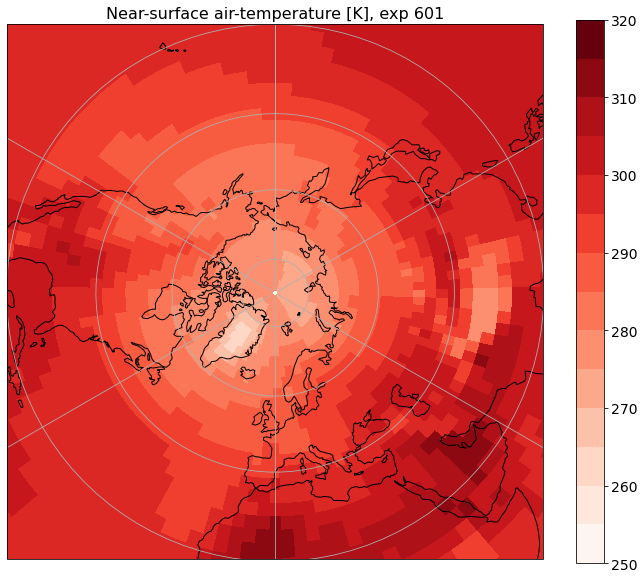

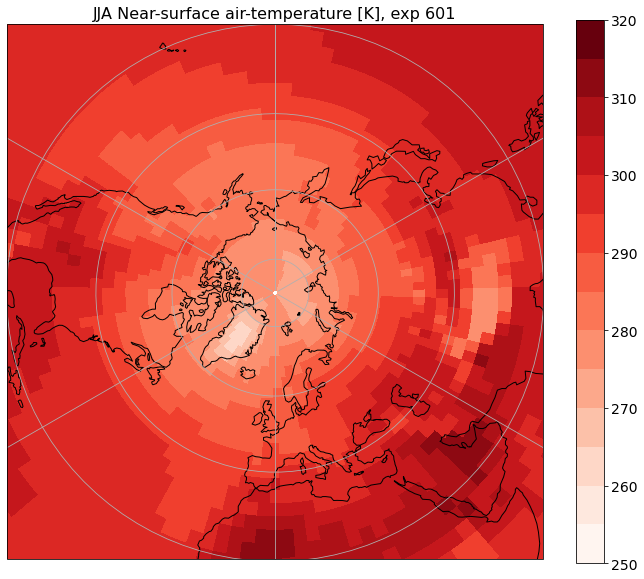

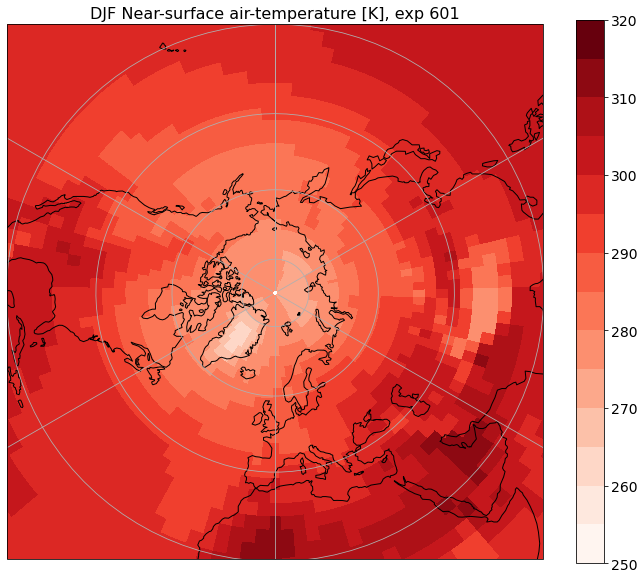

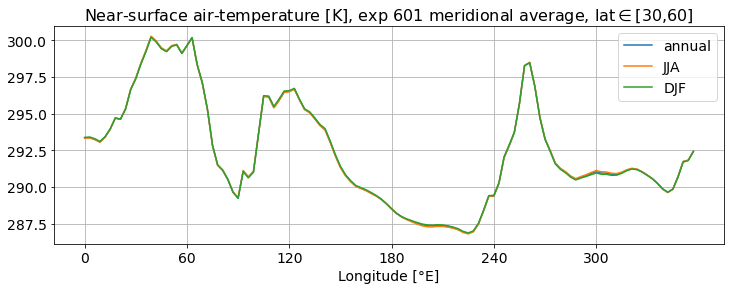

In [152]:
# Annual mean
str_title = var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_exp' + str(exp_num)
plot_map_nps(lon,lat,field,vmin,vmax,cmap,str_title,str_name)

# JJA
str_title = 'JJA ' + var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_JJA_exp' + str(exp_num)
plot_map_nps(lon,lat,field_JJA,vmin,vmax,cmap,str_title,str_name)

# DJF
str_title = 'DJF ' + var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_DJF_exp' + str(exp_num)
plot_map_nps(lon,lat,field_DJF,vmin,vmax,cmap,str_title,str_name)

# August
str_title = 'August ' + var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_aug_exp' + str(exp_num)
#plot_map_nps(lon,lat,field_aug,vmin,vmax,cmap,str_title,str_name)

# Meridional averages
minlat = 30
maxlat = 60

line = compute_meridional_average(lat,field,minlat,maxlat)
line_JJA = compute_meridional_average(lat,field_JJA,minlat,maxlat)
line_DJF = compute_meridional_average(lat,field_DJF,minlat,maxlat)
line_aug = compute_meridional_average(lat,field_aug,minlat,maxlat)

fig = plt.figure(figsize=(12,4))
plt.plot(lon,line,label='annual')
plt.plot(lon,line_JJA,label='JJA')
plt.plot(lon,line_DJF,label='DJF')
#plt.plot(lon,line_aug,'--',label='Aug')
plt.xticks(np.arange(0,360,60))

plt.legend(fontsize=14)

str_title = var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_exp' + str(exp_num)

plt.title(str_title + ' meridional average, lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.grid()

plt.savefig(str_name+'_comparison_meridional_average_.png',bbox_inches='tight')

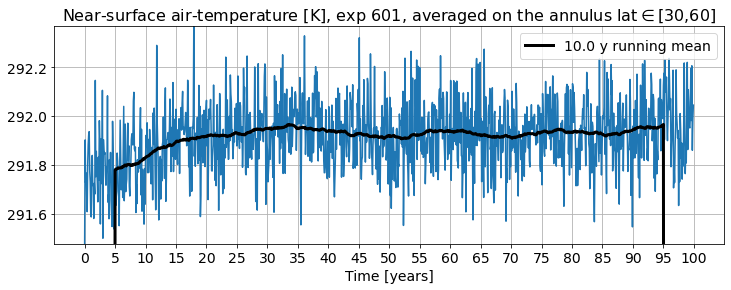

In [153]:
# Time series of the annular average in the same latitudinal range.

timeseries = ds_field.sel(lat=slice(minlat,maxlat)).mean(dim='lat').mean(dim='lon').values
month_time = np.arange(len(ds_field['time'].values))

fig = plt.figure(figsize=(12,4))
#plt.plot(month_time,timeseries)
#plt.xticks(np.arange(0,12*30,12*5))
plt.plot(month_time/12,timeseries)
plt.xticks(np.arange(0,105,5))
N=12*10 # number of months for the moving average
filtered_ts = np.convolve(timeseries, np.ones(N)/N, mode='same')
plt.plot(month_time/12,filtered_ts,'k',linewidth=3,label=str(N/12)+ ' y running mean')
plt.ylim(np.min(timeseries), np.max(timeseries))
plt.legend(fontsize=14)

str_title = var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_exp' + str(exp_num)

plt.title(str_title + ', averaged on the annulus lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.tick_params(axis='both',labelsize=14)
#plt.xlabel('Time [months]',fontsize=14)
plt.xlabel('Time [years]',fontsize=14)
plt.grid()

plt.savefig(str_name+'_timeserie.png',bbox_inches='tight')

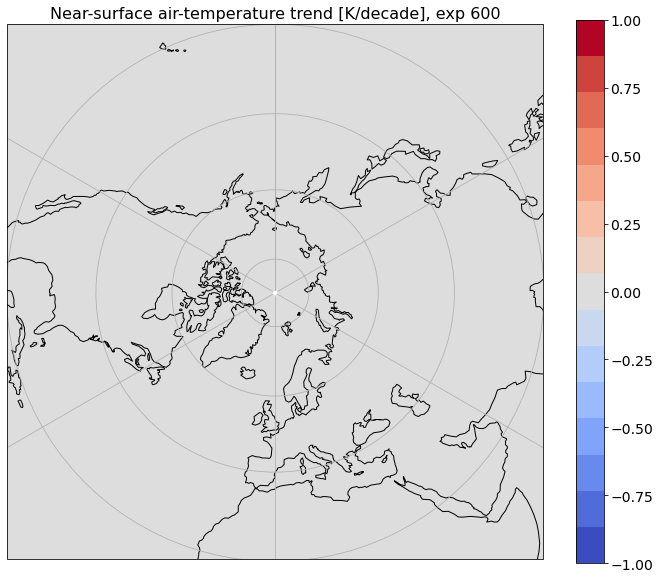

In [123]:
# Temporal trend
str_title = var_label + ' trend [' + units + '/decade], exp ' + str(exp_num)
str_name = varname + '_trend_exp' + str(exp_num)
plot_map_nps(lon,lat,trend,-1,1,cmap_delta,str_title,str_name)


In [124]:
def compute_seasonal_cycle(timeseries):
    timeseries_block = timeseries[0:12]
    for kk in range(1,int(len(timeseries)/12)):
        timeseries_block = np.vstack([timeseries_block,timeseries[kk*12:(kk+1)*12]])
        #print(timeseries_block)

    seasonal_cycle = np.mean(timeseries_block,axis=0)
    seasonal_std = np.std(timeseries_block,axis=0)
    return seasonal_cycle, seasonal_std

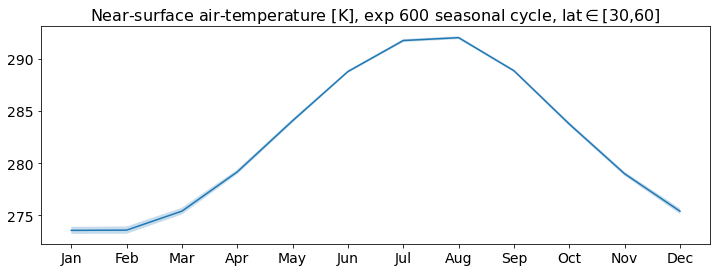

In [125]:
# Compute the seasonal cycle.
seasonal_cycle, seasonal_std = compute_seasonal_cycle(timeseries)

fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(0,12),seasonal_cycle)
plt.fill_between(np.arange(0,12),seasonal_cycle-seasonal_std,seasonal_cycle+seasonal_std, alpha=0.25)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(np.arange(0,12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

str_title = var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_exp' + str(exp_num)

plt.title(str_title + ' seasonal cycle, lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.savefig(str_name+'_seasonal_cycle.png',bbox_inches='tight')

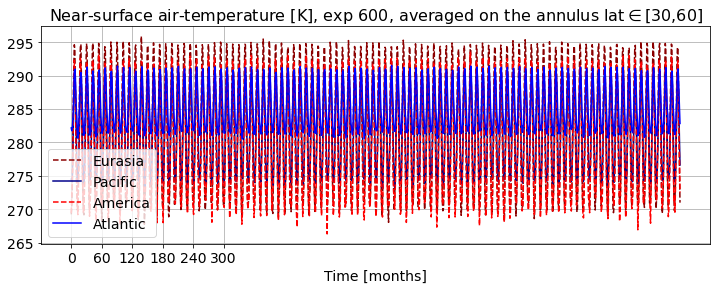

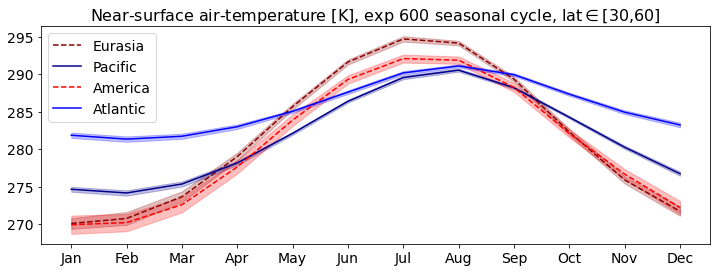

In [126]:
# Define the area averages over Eurasia, the Pacific, America and the Atlantic.
timeseries_eur = ds_field.sel(lat=slice(minlat,maxlat)).sel(lon=slice(0,120)).mean(dim='lat').mean(dim='lon').values
timeseries_pac = ds_field.sel(lat=slice(minlat,maxlat)).sel(lon=slice(120,240)).mean(dim='lat').mean(dim='lon').values
timeseries_ame = ds_field.sel(lat=slice(minlat,maxlat)).sel(lon=slice(240,300)).mean(dim='lat').mean(dim='lon').values
timeseries_atl = ds_field.sel(lat=slice(minlat,maxlat)).sel(lon=slice(300,360)).mean(dim='lat').mean(dim='lon').values

fig = plt.figure(figsize=(12,4))
plt.plot(month_time,timeseries_eur,'--',color='darkred',label='Eurasia')
plt.plot(month_time,timeseries_pac,color='darkblue',label='Pacific')
plt.plot(month_time,timeseries_ame,'--',color='red',label='America')
plt.plot(month_time,timeseries_atl,color='blue',label='Atlantic')
plt.xticks(np.arange(0,12*30,12*5))

#plt.legend(fontsize=14)

str_title = var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_exp' + str(exp_num)

plt.title(str_title + ', averaged on the annulus lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Time [months]',fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()

seas_eur, seas_std_eur = compute_seasonal_cycle(timeseries_eur)
seas_pac, seas_std_pac = compute_seasonal_cycle(timeseries_pac)
seas_ame, seas_std_ame = compute_seasonal_cycle(timeseries_ame)
seas_atl, seas_std_atl = compute_seasonal_cycle(timeseries_atl)

fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(0,12),seas_eur,'--',color='darkred',label='Eurasia')
plt.fill_between(np.arange(0,12),seas_eur-seas_std_eur,seas_eur+seas_std_eur,color='darkred',alpha=0.25)
plt.plot(np.arange(0,12),seas_pac,color='darkblue',label='Pacific')
plt.fill_between(np.arange(0,12),seas_pac-seas_std_pac,seas_pac+seas_std_pac,color='darkblue',alpha=0.25)
plt.plot(np.arange(0,12),seas_ame,'--',color='red',label='America')
plt.fill_between(np.arange(0,12),seas_ame-seas_std_ame,seas_ame+seas_std_ame,color='red',alpha=0.25)
plt.plot(np.arange(0,12),seas_atl,color='blue',label='Atlantic')
plt.fill_between(np.arange(0,12),seas_atl-seas_std_atl,seas_atl+seas_std_atl,color='blue',alpha=0.25)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(np.arange(0,12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(fontsize=14)

str_title = var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_exp' + str(exp_num)

plt.title(str_title + ' seasonal cycle, lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.savefig(str_name+'_seasonal_cycle_areas.png',bbox_inches='tight')

In [ ]:
# Differences with respect to the reference run

# Annual mean
str_title = var_label + ' [' + units + '], exp' + str(exp_num) + ' - exp' + str(ref_num) 
str_name = varname + '_exp' + str(exp_num) + '-exp' + str(ref_num)
####plot_map_nps(lon,lat,field-field_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)
plot_map_nps_diff(lon,lat,field,field_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)

# JJA
str_title = 'JJA ' + var_label + ' [' + units + '], exp' + str(exp_num) + ' - exp' + str(ref_num) 
str_name = varname + '_JJA_exp' + str(exp_num)+ '-exp' + str(ref_num)
####plot_map_nps(lon,lat,field_JJA-field_JJA_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)
plot_map_nps_diff(lon,lat,field_JJA,field_JJA_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)

# DJF
str_title = 'DJF ' + var_label + ' [' + units + '], exp' + str(exp_num) + ' - exp' + str(ref_num) 
str_name = varname + '_DJF_exp' + str(exp_num)+ '-exp' + str(ref_num)
####plot_map_nps(lon,lat,field_DJF-field_DJF_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)
#plot_map_nps_diff(lon,lat,field_DJF,field_DJF_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)


In [ ]:
# Compare different runs - select the season according to the experiments
exp_list = [107,502,504] # 107 - JJA, 502 - all, 504 - all
exp_list = [107,502,506,507] # 107 - aug, 502 - all, 506 - aug, 507 - all
exp_list = [107,500,506] # 107 - DJF, 500 - all, 506 - DJF
exp_list = [107,502,506] # 107 - JJA, 502 - all, 506 - JJA
exp_list = [107,502,506,509] # 107 - JJA, 502 - all, 506 - JJA, 509 - all
exp_list = [107,502,506,510] # 107 - JJA, 502 - all, 506 - JJA, 510 - all
exp_list = [107,502,506,510,511] # 107 - JJA, 502 - all, 506 - JJA, 510 - all, 511 - all
#exp_list = [107,502,504,506,508] # 107 - JJA, 502 - all, 504 - all, 506 - JJA, 508 - JJA
exp_list = [107,506,512,513,514] # 107 - JJA, 506 - JJA, 512 - all, 513 - all, 514 - JJA

fig = plt.figure(figsize=(12,4))



for exp_num in exp_list:
    linestyle = '-'
    path2output = './output_elastyc/exp_'+str(exp_num)+'/'
    ds_attm = xr.open_dataset(path2output+'attm'+str(exp_num)+'.nc')

    field, field_seasonal, ds_field, field_monthly = get_var(ds_attm,varname)
    
    field_JJA = field_seasonal.sel(season='JJA').values
    field_DJF = field_seasonal.sel(season='DJF').values
    field_aug = field_monthly.sel(month=8).values

    lon = ds_attm['lon'].values
    lat = ds_attm['lat'].values
    
    if exp_num==107:
        line = compute_meridional_average(lat,field_JJA,minlat,maxlat)
        label = str(exp_num) + '-JJA'
    elif exp_num==500:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-DJF*'      
    elif exp_num==502:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*'      
    elif exp_num==504:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*'      
    elif exp_num==506:
        line = compute_meridional_average(lat,field_JJA,minlat,maxlat)
        label = str(exp_num) + '-JJA'      
    elif exp_num==507:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-Aug*'          
    elif exp_num==508:
        line = compute_meridional_average(lat,field_JJA,minlat,maxlat)
        label = str(exp_num) + '-JJA'  
    elif exp_num==509:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*'  
    elif exp_num==510:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*'  
    elif exp_num==511:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*'  
        linestyle = '--'
    elif exp_num==512:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*' 
        #linestyle = 'o'
    elif exp_num==513:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-JJA*'  
        linestyle = '--'
    elif exp_num==514:
        line = compute_meridional_average(lat,field_JJA,minlat,maxlat)
        label = str(exp_num) + '-JJA'  
        linestyle = '--'
    else:
        line = compute_meridional_average(lat,field,minlat,maxlat)
        label = str(exp_num) + '-annual'  
        
    plt.plot(lon,line,linestyle,label=label)
    plt.xticks(np.arange(0,360,60))

plt.legend(fontsize=14)

str_title = var_label + ' [' + units + ']'
str_name = varname

plt.title(str_title + ' meridional average, lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.grid()

plt.savefig(str_name+'_comparison_meridional_average_'+str(exp_list)+'.png',bbox_inches='tight')

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 120, time: 36500)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2079-12-31
  * lon      (lon) float64 0.0 3.0 6.0 9.0 12.0 ... 348.0 351.0 354.0 357.0
  * lat      (lat) float64 -87.72 -84.77 -81.81 -78.83 ... 81.81 84.77 87.72
Data variables:
    mslp     (time, lat, lon) float32 ...
    temp0    (time, lat, lon) float32 ...
    gh_500   (time, lat, lon) float32 ...
    u_850    (time, lat, lon) float32 ...
    v_850    (time, lat, lon) float32 ...
    q_850    (time, lat, lon) float32 ...
    u_200    (time, lat, lon) float32 ...
    v_200    (time, lat, lon) float32 ...
    prec     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 17 11:24:48 2025: cdo -f nc import_binary daytm600....
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

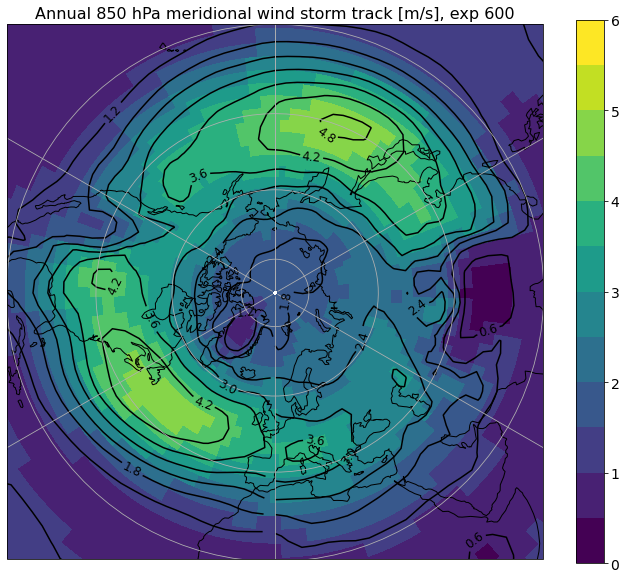

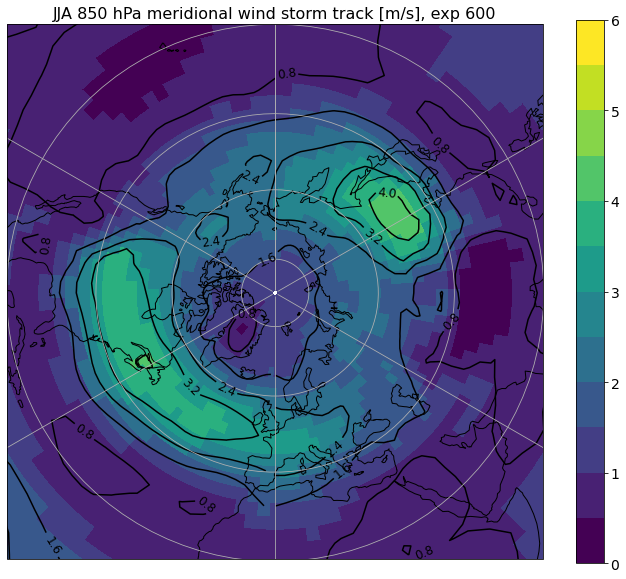

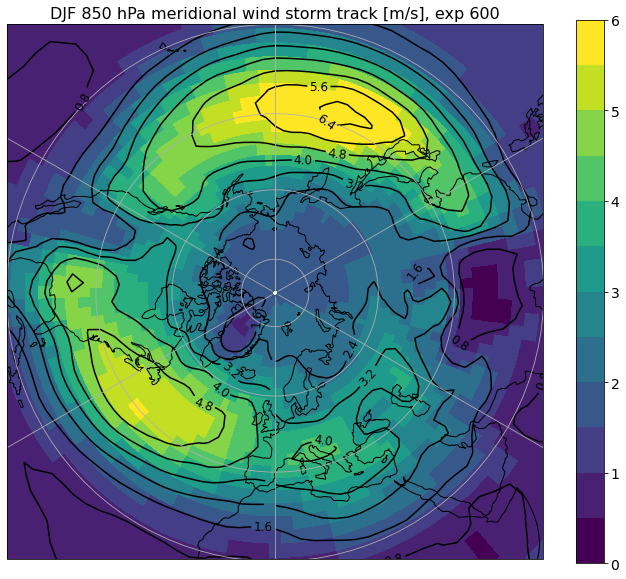

In [113]:
# Plot the storm track for the selected variable

strack_varname = 'gh_500'; var_label = '500 hPa geopotential height'; units = 'm'; vmax= 60; vmin = 0; ncol = 12; cmap = 'viridis';
strack_varname = 'v_850'; var_label = '850 hPa meridional wind'; units = 'm/s'; vmax= 6; vmin = 0; ncol = 12; cmap = 'viridis';
#strack_varname = 'mslp'; var_label = 'Mean sea level pressure'; units = 'hPa'; vmax= 7; vmin = 0; ncol = 14; cmap = 'viridis';


##### that's it #####
cmap = plt.get_cmap(cmap,ncol)
strack,strack_JJA,strack_DJF = get_storm_track(ds_daily,varname=strack_varname)

# annual
str_title = 'Annual '+var_label+' storm track ['+units+'], exp ' + str(exp_num)
str_name = 'strack_'+strack_varname+'_exp' + str(exp_num)
plot_map_nps_strack(lon,lat,strack,vmin,vmax,cmap,str_title,str_name)

# JJA
str_title = 'JJA '+var_label+' storm track ['+units+'], exp ' + str(exp_num)
str_name = 'strack_'+strack_varname+'_JJA_exp' + str(exp_num)
plot_map_nps_strack(lon,lat,strack_JJA,vmin,vmax,cmap,str_title,str_name)

# DJF
str_title = 'DJF '+var_label+' storm track ['+units+'], exp ' + str(exp_num)
str_name = 'strack_'+strack_varname+'_DJF_exp' + str(exp_num)
plot_map_nps_strack(lon,lat,strack_DJF,vmin,vmax,cmap,str_title,str_name)

In [ ]:
# asw is the soil water availability

Compute the soil water availability which depends on vegetation fraction and some other fixed parameters as

$\alpha_{sw} = [D_{top}W_{top}+f_{veg}D_{root}\max{(W_{root}-W_{wil},0)}]/[D_{top}W_{cap}+D_{root}(W_{cap}-W_{wil})]$

with $W_{top}$ and $W_{root}$ being the water content in the first and second soil layer (contained in the soil moisture climatological forcing file); $D_{top}$ and $D_{root}$ the respective depths (set to 1 and 3 m, respectively); $W_{wil}$ and $W_{cap}$ are the wilting point and the field capacity soil wetness set to 0.17 and 0.30, respectively in the cls_inphys.h file.

The vegetation fraction is computed by merging the high and low vegetation fraction contained in the aclim_era5_sfc_1981_2010 file as follow

$f_{veg} = \min(f_{veg,H}+0.8f_{veg,L},1) $

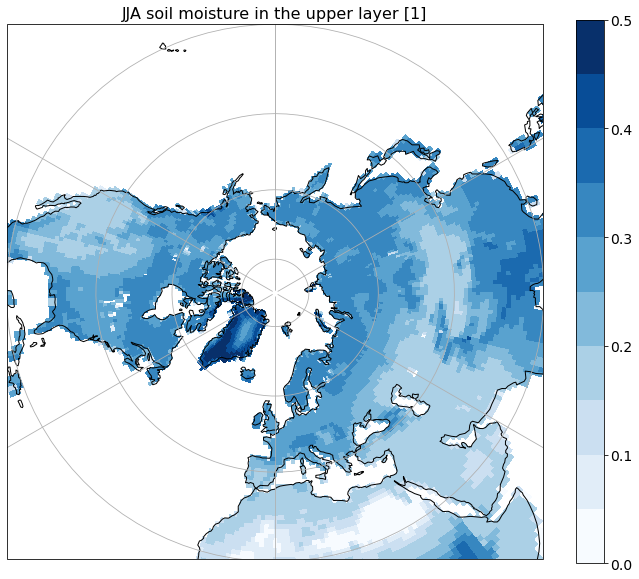

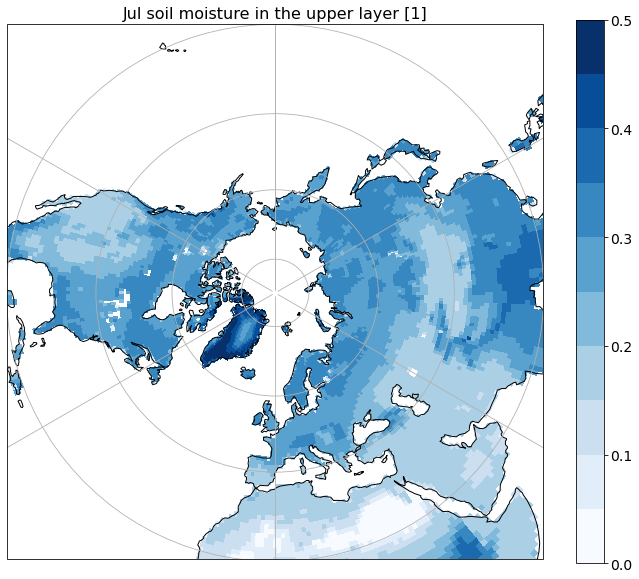

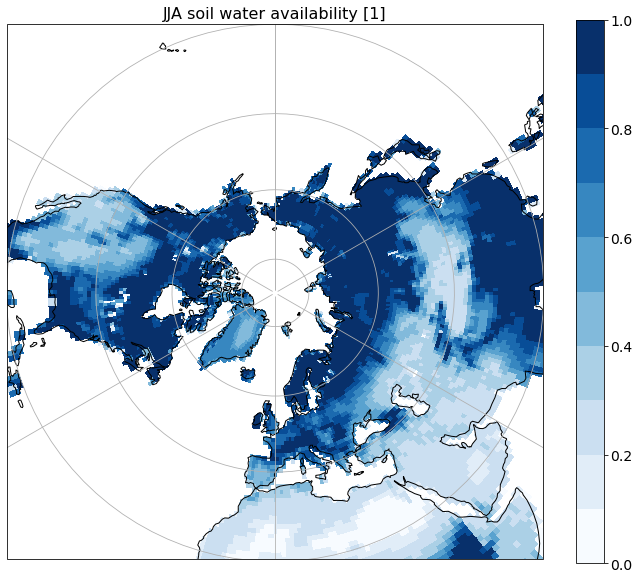

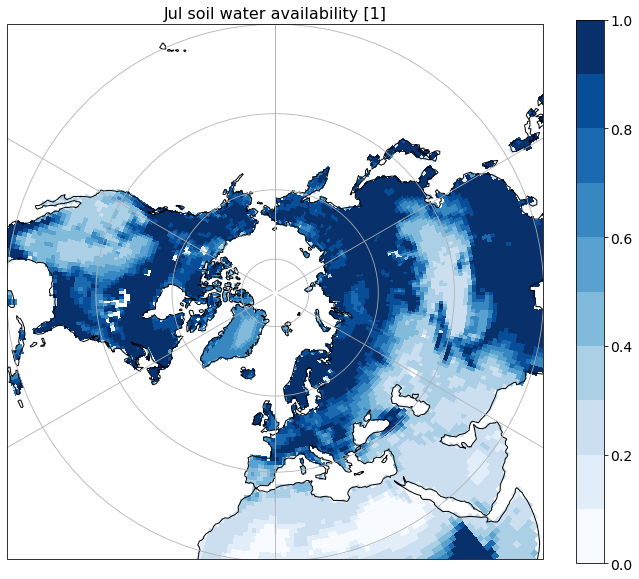

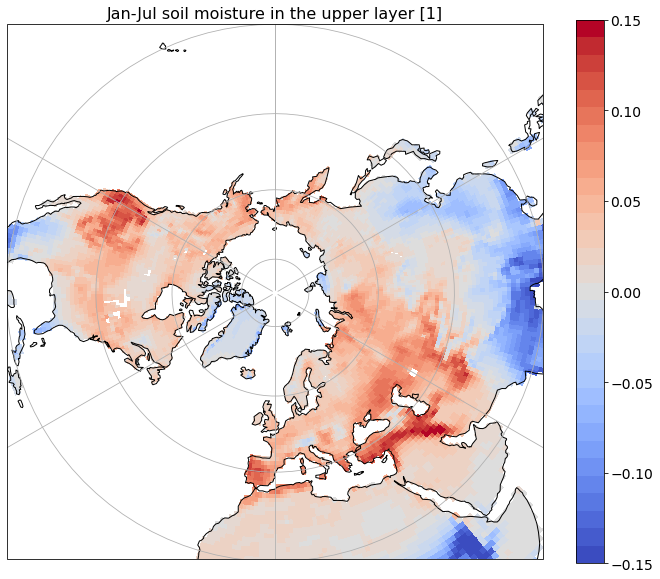

In [155]:
Wwil = 0.17
Wcap = 0.3
Dtop = 1.
Droot = 3.

month_number = 7
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

aclim_file = '/home/agostino/Desktop/SPEEDY/dynamic_topography/aclim_era5_sfc_1981_2010.nc'
swet_file = '/home/agostino/Desktop/SPEEDY/speedy_seasonal_forcing/mclim_erain_swet.nc' # monthly resolution
swet_file_JJA = '/home/agostino/Desktop/SPEEDY/speedy_seasonal_forcing/swet_JJA_speedygrid.nc' # JJA averaged only

ds_aclim = xr.open_dataset(aclim_file)
ds_swet = xr.open_dataset(swet_file)
ds_swet_JJA = xr.open_dataset(swet_file_JJA)

# Compute the vegetation fraction by combining low and high vegetation fraction from the aclim file.
ds_fveg = np.minimum(ds_aclim['vegh']+0.8*ds_aclim['vegl'],1)
fveg = ds_fveg[0,0,:,:].values

# Compute the soil water availability for the perpetual JJA and for a given month.
def asw(Wtop,Wroot,fveg,Dtop,Droot,Wwil,Wcap):
    asw = (Dtop*Wtop + fveg*Droot*np.maximum(Wroot-Wwil,0))/(Dtop*Wcap + Droot*(Wcap-Wwil))
    return asw


wtop_JJA = ds_swet_JJA['swl1'][0].values
wroot_JJA = ds_swet_JJA['swl2'][0].values
wtop_month = ds_swet['swl1'].isel(time=month_number-1).isel(lev=0).values
wroot_month = ds_swet['swl2'].isel(time=month_number-1).isel(lev=0).values
asw_JJA=asw(wtop_JJA,wroot_JJA,fveg,Dtop,Droot,Wwil,Wcap)
asw_month=asw(wtop_month,wroot_month,fveg,Dtop,Droot,Wwil,Wcap)

lon_aclim = ds_aclim['lon'].values
lat_aclim = ds_aclim['lat'].values

# Reverse the y axis.

wtop_JJA_y = np.flipud(wtop_JJA)
wtop_month_y = np.flipud(wtop_month)
asw_JJA_y = np.flipud(asw_JJA)
asw_month_y = np.flipud(asw_month)

# Plot some interesting variables.

# Soil moisture in the upper layer in JJA and in the month considered.
cmap = plt.get_cmap('Blues',10)
str_title = 'JJA soil moisture in the upper layer [1]'
str_name = 'swl1_JJA'
plot_map_nps(lon_aclim,lat_aclim,wtop_JJA_y,0,0.5,cmap,str_title,str_name)

str_title = month_list[month_number-1]+' soil moisture in the upper layer [1]'
str_name = 'swl1_month_'+month_list[month_number-1]
plot_map_nps(lon_aclim,lat_aclim,wtop_month_y,0,0.5,cmap,str_title,str_name)

# Soil water availability
str_title = 'JJA soil water availability [1]'
str_name = 'asw_JJA_soil_water_availability'
plot_map_nps(lon_aclim,lat_aclim,asw_JJA_y,0,1,cmap,str_title,str_name)

str_title = month_list[month_number-1]+' soil water availability [1]'
str_name = 'asw_'+month_list[month_number-1]+'_soil_water_availability'
plot_map_nps(lon_aclim,lat_aclim,asw_month_y,0,1,cmap,str_title,str_name)

# Soil moisture difference Jan-Jul
wtop_jan = ds_swet['swl1'].isel(time=0).isel(lev=0).values
wtop_jul = ds_swet['swl1'].isel(time=6).isel(lev=0).values
diff_wtop = np.flipud(wtop_jan-wtop_jul)

cmap_delta = plt.get_cmap('coolwarm',31)
str_title = 'Jan-Jul soil moisture in the upper layer [1]'
str_name = 'swl1_Jan-Jul'
plot_map_nps(lon_aclim,lat_aclim,diff_wtop,-0.15,0.15,cmap_delta,str_title,str_name)


In [ ]:
# Read also the forcing land temperature
aclim_file = '/home/agostino/Desktop/SPEEDY/dynamic_topography/aclim_era5_sfc_1981_2010.nc'
stl1m_file = '/home/agostino/Desktop/SPEEDY/speedy_seasonal_forcing/mclim_erain_stl1m.nc' # monthly resolution

ds_aclim = xr.open_dataset(aclim_file)
ds_stl1m = xr.open_dataset(stl1m_file)


cmap = plt.get_cmap('Reds',30)

stl1m_jan = ds_stl1m['s1l1m'].isel(time=0).isel(lev=0).values

str_title = 'Jan soil temperature [K]'
str_name = 'stl1m_Jan'
plot_map_nps(lon_aclim,lat_aclim,np.flipud(stl1m_jan),273,303,cmap,str_title,str_name)


In [ ]:
# ERA5 surface fluxes # they are accumulated over one day and measured in J/m2
ds_era = xr.open_dataset('era5_monthly_surface_fluxes.nc')

varname = 'sshf'; var_label = 'Sensible heat flux'; units = 'W m$^{-2}$'; vmax = 162.5; vmin = -vmax; ncol = 13; cmap = 'coolwarm'
varname = 'slhf'; var_label = 'Latent heat flux'; units = 'W m$^{-2}$'; vmax = 325; vmin = -vmax; ncol = 13; cmap = 'coolwarm'

ds_field = -ds_era[varname]/(24*60*60)
ds_field_season = ds_field.groupby('valid_time.season').mean(dim='valid_time')

field = ds_field.mean(dim='valid_time').values
field_JJA = ds_field_season.sel(season='JJA').values
field_DJF = ds_field_season.sel(season='DJF').values

lon_era = ds_era['longitude'].values
lat_era = ds_era['latitude'].values

cmap = plt.get_cmap(cmap,ncol)
minlat=20
maxlat=60

In [ ]:
# Annual mean
str_title = 'ERA5 '+var_label+' [W m$^{-2}$]'
str_name = varname + '_era5'
plot_map_nps(lon_era,lat_era,field,vmin,vmax,cmap,str_title,str_name)

# JJA
str_title = 'JJA ERA5 '+var_label+' [W m$^{-2}$]'
str_name = varname + '_JJA_era5'
plot_map_nps(lon_era,lat_era,field_JJA,vmin,vmax,cmap,str_title,str_name)

# DJF
str_title = 'DJF ERA5 '+var_label+' [W m$^{-2}$]'
str_name = varname + '_DJF_era5'
plot_map_nps(lon_era,lat_era,field_DJF,vmin,vmax,cmap,str_title,str_name)

# Meridional averages
line = compute_meridional_average(lat_era,field,minlat,maxlat)
line_JJA = compute_meridional_average(lat_era,field_JJA,minlat,maxlat)
line_DJF = compute_meridional_average(lat_era,field_DJF,minlat,maxlat)

fig = plt.figure(figsize=(12,4))
plt.plot(lon_era,line,label='annual')
plt.plot(lon_era,line_JJA,label='JJA')
plt.plot(lon_era,line_DJF,label='DJF')
plt.xticks(np.arange(0,360,60))

plt.legend(fontsize=14)

str_title = var_label + ' [' + units + '], ERA5'
str_name = varname + '_exp' + str(exp_num)

plt.title(str_title + ' meridional average, lat$\in$['+str(minlat)+','+str(maxlat)+']',fontsize=16)
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.grid()

plt.savefig(str_name+'_comparison_meridional_average_era5.png',bbox_inches='tight')

In [ ]:
ds_attm

In [ ]:
tt = 10
delta_t_skin = ds_attm['skint']-ds_attm['st']
delta_t_skin[tt].plot()

In [ ]:
ds_attm['nhfsfc'][tt].plot()

In [ ]:
# All fluxes in W/m2
# ssr: surface shortwave radiation flux (dw)
# slr: surface longwave radiation flux (uw)
# shf: sensible heat flux (uw)
# lhf = evap*rhow*Lv*conversion (uw)
rhow = 1e3 # [kg/m3]
Lv = 2.5e6 # [J/kg]
conversion = 1/86400e3 # to go from mm/d to m/s

somma = ds_attm['ssr'][tt] - ds_attm['slr'][tt] - ds_attm['shf'][tt] - ds_attm['evap'][tt]*rhow*Lv*conversion
somma.plot() # This is very similar to 'nhfsfc'

In [ ]:
diff = somma-ds_attm['nhfsfc'][tt]
diff.plot()

In [ ]:
x = ds_attm['nhfsfc'][tt].values.flatten()
y = somma.values.flatten()
plt.scatter(x,y)
plt.xlabel('nhfsfc [W/m2]')
plt.ylabel('sum of heat fluxes [W/m2]')

In [ ]:
z = delta_t_skin[tt].values.flatten()
plt.scatter(x,z)
plt.xlabel('nhfsfc [W/m2]')
plt.ylabel('delta T_skin [K]')

In [ ]:
# Plot the difference between the 502 long-term tsr average and the July 107 average.

field_jul = field_monthly.sel(month=7).values
field_jul_ref = field_monthly_ref.sel(month=7).values

# July
str_title = 'July ' + var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_jul_exp' + str(exp_num)
plot_map_nps(lon,lat,field_jul,vmin,vmax,cmap,str_title,str_name)

# July - delta 
str_title = 'July ' + var_label + ' [' + units + '], exp' + str(exp_num) + ' - exp' + str(ref_num) 
str_name = varname + '_jul_exp' + str(exp_num)+ '-exp' + str(ref_num)
plot_map_nps(lon,lat,field_jul-field_jul_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)

field_jan = field_monthly.sel(month=1).values
field_jan_ref = field_monthly_ref.sel(month=1).values

# January
str_title = 'January ' + var_label + ' [' + units + '], exp ' + str(exp_num)
str_name = varname + '_jan_exp' + str(exp_num)
plot_map_nps(lon,lat,field_jan,vmin,vmax,cmap,str_title,str_name)
plot_map_sps(lon,lat,field_jan,vmin,vmax,cmap,str_title,str_name)

# January - delta 
str_title = 'January ' + var_label + ' [' + units + '], exp' + str(exp_num) + ' - exp' + str(ref_num) 
str_name = varname + '_jan_exp' + str(exp_num)+ '-exp' + str(ref_num)
plot_map_nps(lon,lat,field_jan-field_jan_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)
plot_map_sps(lon,lat,field_jan-field_jan_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)


In [ ]:
# Check the max Eady growth rate

rhow = 1e3 # [kg/m3] water density
Lv = 2.5e6 # [J/kg] latent heat of vaporization
Rd = 287.04 # [J/K/kg] dry air gas constant
cvd = 719 # [J/K/kg] dry air specific heat at constant volume (Romps, 2017)
cpd = Rd + cvd # dry air specific heat at constant pressure (Romps, 2017)
p0 = 1000 # [hPa] reference pressure for potential temperature calculation
g = 9.81 # [m/s] acceleration due to gravity
Omega = 7.292e-5 # [1/s] Earth rotation rate


lon=ds_attm['lon'].values
lat=ds_attm['lat'].values
cmap = plt.get_cmap('viridis',64)

ptop = 500
pbot = 850
# Coriolis parameter
f = 2*Omega*np.sin(ds_attm['lat']*np.pi/180)
plt.plot(lat,f)
plt.xlabel('Latitude [°N]',fontsize=14)
plt.ylabel('Coriolis parameter, $f$ [s$^{-1}$]',fontsize=14)
plt.show()
# Wind shear
wspd = np.sqrt(ds_attm['u']**2+ds_attm['v']**2)
field = wspd.sel(lev=ptop).mean(dim='time').values
plot_map_nps(lon,lat,field,0,15,cmap,'wind speed at ptop [m/s]','trash')
field = wspd.sel(lev=pbot).mean(dim='time').values
plot_map_nps(lon,lat,field,0,15,cmap,'wind speed at pbot [m/s]','trash')
du = wspd.sel(lev=ptop)-wspd.sel(lev=pbot)
field = du.mean(dim='time').values
cmap = plt.get_cmap('coolwarm',20)
plot_map_nps(lon,lat,field,-10,10,cmap,'du [m/s]','trash')

cmap = plt.get_cmap('viridis',64)
field = ds_attm['gh'].sel(lev=ptop).mean(dim='time').values
plot_map_nps(lon,lat,field,5.4e3,6e3,cmap,'geopotential height at ptop [m]','trash')
field = ds_attm['gh'].sel(lev=pbot).mean(dim='time').values
plot_map_nps(lon,lat,field,1.2e3,1.8e3,cmap,'geopotential height at pbot [m]','trash')
dz = ds_attm['gh'].sel(lev=ptop)-ds_attm['gh'].sel(lev=pbot)
field = dz.mean(dim='time').values
plot_map_nps(lon,lat,field,4.2e3,4.6e3,cmap,'dz [m]','trash')

field = np.abs(du/dz).mean(dim='time').values
plot_map_nps(lon,lat,field,0,3e-3,cmap,'du/dz [1/s]','trash')


# Brunt-Vaisala frequency
theta, theta_seasonal, ds_theta, theta_monthly = get_var(ds_attm,'theta')
field = ds_theta.sel(lev=ptop).mean(dim='time').values
plot_map_nps(lon,lat,field,250,350,cmap,'theta at ptop [K]','trash')
field = ds_theta.sel(lev=pbot).mean(dim='time').values
plot_map_nps(lon,lat,field,250,350,cmap,'theta at pbot [K]','trash')

N2 = g/ds_theta.sel(lev=ptop)*((ds_theta.sel(lev=ptop)-ds_theta.sel(lev=pbot))/dz)
field = np.sqrt(N2).mean(dim='time').values
plot_map_nps(lon,lat,field,0,0.02,cmap,'N [1/s]','trash')

ds_field = 86400*0.31*f*np.abs(du/dz)/np.sqrt(N2)

#plot_map_nps(lon,lat,field_jan-field_jan_ref,vmin_delta,vmax_delta,cmap_delta,str_title,str_name)
# The numbers look ok, with respect to the typical values indicated in Vallis:
# chapter 6, the Eady problem, 6.5.2
# H ~ 10 km, U ~ 10 m/s -> du/dz ~ 1e-3 1/s
# N ~ 1e-2 1/s
# f ~ 1e-4 1/s
# so that egr ~ 0.3 (f/N)(U/H) ~ 0.26 1/day

In [ ]:
fit = ds_field.polyfit(dim='time',deg=1)

trend = fit.polyfit_coefficients.sel(degree=1).values
pc = plt.pcolormesh(trend*60*60*24*365*10)
plt.colorbar(pc)

In [ ]:
# Open the daily files, if available!
ds_daily = xr.open_dataset(path2output+'daytm'+str(exp_num)+'.nc')
ds_daily

In [ ]:
tobefiltered = ds_daily['gh_500'].sel(lon=0,lat=45.,method='nearest').isel(time=slice(1,360))
from scipy.fft import fft, fftshift, fftfreq, ifft

signal = ds_daily['gh_500'].sel(lon=0,lat=45.,method='nearest').isel(time=slice(1,20*360)).values
t = np.arange(len(signal))

plt.plot(t,signal)
plt.xlabel('time [d]')
plt.ylabel('test signal')
plt.show()
sp = fft(signal-np.mean(signal))
freq = fftfreq(len(t))

plt.plot(freq,np.abs(sp)**2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('frequency [1/d]')
plt.ylabel('power spectrum')
plt.xlim(0,0.5)
plt.vlines(1/365,1,1e8,'k')
plt.vlines(1/2,1,1e8,'k') # This is the Nyquist frequency for a signal with daily sampling
plt.vlines(1/7,1,1e8,'k')

plt.show()

# Define a rectangular filter to highpass the signal at 1/7d.
ffilter = np.ones_like(freq)*np.heaviside(freq-1/7,0)+np.ones_like(freq)*np.heaviside(-freq-1/7,0)
plt.plot(freq,ffilter,'.')
plt.xlabel('frequency [1/d]')
plt.ylabel('filter shape')
plt.show()

# Invert the signal
filtered = ifft(ffilter*sp)
plt.plot(t,filtered)

[   0    1    2 ... 3646 3647 3648]
(3649, 60, 120)


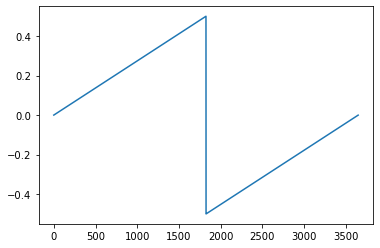

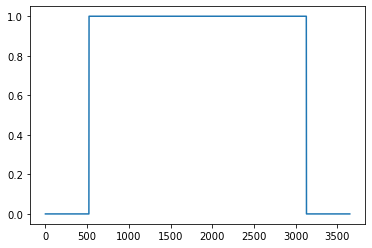

(3649,)
(3649, 60, 120)


In [21]:
varname = 'gh_500'
from scipy.fft import fft, fftshift, fftfreq, ifft

signal = ds_daily[varname].isel(time=slice(1,10*365)).values
t = np.arange(np.shape(signal)[0])
print(t)
sp = fft(signal-np.mean(signal),axis=0)
print(np.shape(sp))
freq = fftfreq(len(t))
plt.plot(freq)
plt.show()
ffilter = np.ones_like(freq)*np.heaviside(freq-1/7,0)+np.ones_like(freq)*np.heaviside(-freq-1/7,0)
plt.plot(ffilter)
plt.show()
print(np.shape(ffilter))
filtered = ifft(ffilter[:,np.newaxis,np.newaxis]*sp,axis=0)

strack = np.std(filtered,axis=0)

print(np.shape(ffilter[:,np.newaxis,np.newaxis]*sp))

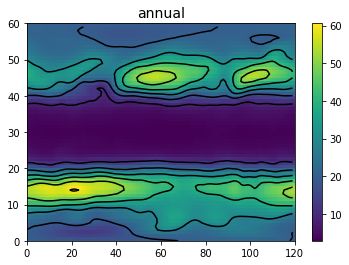

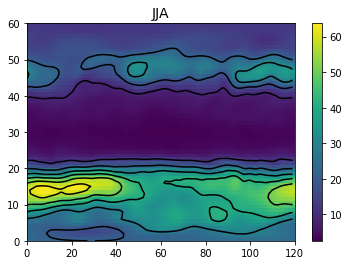

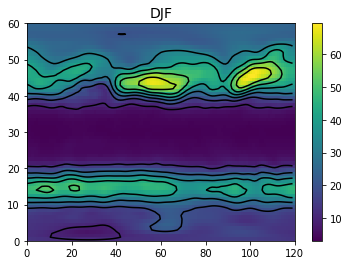

In [107]:
test_strack,test_strack_JJA,test_strack_DJF = get_storm_track(ds_daily)

pc = plt.pcolormesh(test_strack)
plt.contour(test_strack,levels=np.arange(10,70,10),colors='k')
plt.colorbar(pc)
plt.title('annual',fontsize=14)
plt.show()

pc = plt.pcolormesh(test_strack_JJA)
plt.contour(test_strack_JJA,levels=np.arange(10,70,10),colors='k')
plt.colorbar(pc)
plt.title('JJA',fontsize=14)
plt.show()

pc = plt.pcolormesh(test_strack_DJF)
plt.contour(test_strack_DJF,levels=np.arange(10,70,10),colors='k')
plt.colorbar(pc)
plt.title('DJF',fontsize=14)
plt.show()

DatasetGroupBy, grouped over 'season' 
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [102]:
varname='gh_500'
    
from scipy.fft import fft, fftshift, fftfreq, ifft

nyears = 20 # number of years to be selected
# Do not distinguish the seasons.
signal = ds_daily[varname].isel(time=slice(1,nyears*365)).values
t = np.arange(np.shape(signal)[0])
sp = fft(signal-np.mean(signal),axis=0)
freq = fftfreq(len(t))
ffilter = np.ones_like(freq)*np.heaviside(freq-1/7,0)+np.ones_like(freq)*np.heaviside(-freq-1/7,0)
filtered = ifft(ffilter[:,np.newaxis,np.newaxis]*sp,axis=0)

strack = np.std(filtered,axis=0)

# To separate the storm tracks by season we assume that the output file starts in January.
first_file = 1
for kk in range(nyears):
    if first_file:
        #filt_JJA=filtered[kk*12+5:kk*12+8]
        #filt_JF=filtered[kk*12:kk*12+2]
        #filt_D=filtered[kk*12+11:(kk+1)*12]
        filt_JJA=filtered[kk*365+151:kk*365+243]
        filt_JF=filtered[kk*365:kk*365+59]
        filt_D=filtered[kk*365+334:kk*365+365]
        filt_DJF=np.concatenate((filt_JF,filt_D),axis=0)
        first_file=0
    else:
        #filt_JJA=np.concatenate((filt_JJA,filtered[kk*12+5:kk*12+8]),axis=0)
        #filt_JF=filtered[kk*12:kk*12+2]
        #filt_D=filtered[kk*12+11:(kk+1)*12]
        filt_JJA=np.concatenate((filt_JJA,filtered[kk*365+151:kk*365+243]),axis=0)
        filt_JF=filtered[kk*365:kk*365+59]
        filt_D=filtered[kk*365+334:kk*365+365]
        filt_DJF=np.concatenate((filt_DJF,filt_JF,filt_D),axis=0)
    print(np.shape(filt_JJA),np.shape(filt_DJF))
strack_JJA = np.std(filt_JJA,axis=0)
strack_DJF = np.std(filt_DJF,axis=0)

(92, 60, 120) (90, 60, 120)
(184, 60, 120) (180, 60, 120)
(276, 60, 120) (270, 60, 120)
(368, 60, 120) (360, 60, 120)
(460, 60, 120) (450, 60, 120)
(552, 60, 120) (540, 60, 120)
(644, 60, 120) (630, 60, 120)
(736, 60, 120) (720, 60, 120)
(828, 60, 120) (810, 60, 120)
(920, 60, 120) (900, 60, 120)
(1012, 60, 120) (990, 60, 120)
(1104, 60, 120) (1080, 60, 120)
(1196, 60, 120) (1170, 60, 120)
(1288, 60, 120) (1260, 60, 120)
(1380, 60, 120) (1350, 60, 120)
(1472, 60, 120) (1440, 60, 120)
(1564, 60, 120) (1530, 60, 120)
(1656, 60, 120) (1620, 60, 120)
(1748, 60, 120) (1710, 60, 120)
(1840, 60, 120) (1799, 60, 120)


/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


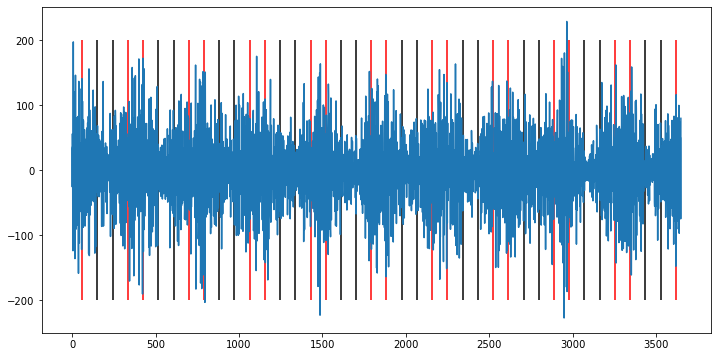

In [110]:
nyears = 10

plt.figure(figsize=(12,6))
plt.plot(filtered[:365*nyears,45,100])
for kk in range(nyears):
    # JJA: black
    plt.vlines(kk*365+151,-200,200,'k')
    plt.vlines(kk*365+243,-200,200,'k')
    # DJF: red
    #plt.vlines(kk*365,-200,200,'r')
    plt.vlines(kk*365+59,-200,200,'r')
    plt.vlines(kk*365+334,-200,200,'r')
    #plt.vlines(kk*365+365,-200,200,'r')
